In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


import sys 
sys.path.append('/home/mahakaran/NK-paper-12-5-24-version/nk-ml-paper2-2024/pscapes')
sys.path.append('/home/mahakaran/NK-paper-12-5-24-version/nk-ml-paper2-2024/nk-ml-2024')


import numpy as np
import itertools
from sklearn.utils import gen_batches

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

from torch.utils.data import Subset

from sklearn.model_selection import train_test_split
from pscapes.landscape_models import make_NK
from pscapes.landscape_class import Protein_Landscape
from pscapes.utils import dict_to_np_array

from src.architectures.test_transformer import AminoAcidTransformer
from src.architectures.ml_utils import train_model, get_trainable_params

In [2]:
AA_ALPHABET = 'ACDEFG'
SEQ_LENGTH  = 6
K_VALS   = list(range(SEQ_LENGTH))

In [3]:
NK_LANDSCAPES = [make_NK(SEQ_LENGTH, k, AA_ALPHABET, np.random.uniform) for k in K_VALS]

In [4]:
LANDSCAPES = [Protein_Landscape(data=dict_to_np_array(i), amino_acids=AA_ALPHABET) for i in NK_LANDSCAPES]

In [5]:
%%capture

#fit one hot
[i.fit_OHE() for i in LANDSCAPES]

In [6]:
#MLP_params
input_size = SEQ_LENGTH * len(AA_ALPHABET)  # Total input size after flattening
input_size

36

/home/mahakaran/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [8]:
batch_size1 = 32
LANDSCAPES[0].fitnesses.shape

(46656,)

In [9]:
LANDSCAPES_OHE = [np.array(i.one_hot_encodings) for i in LANDSCAPES]

X_OHE = LANDSCAPES_OHE
Y_OHE = [i.fitnesses.reshape(-1,1).astype(float) for i in LANDSCAPES]
XY_OHE = [list(zip(torch.from_numpy(X_OHE[i]).to(torch.float32), torch.from_numpy(Y_OHE[i]).to(torch.float32))) for i in range(len(X_OHE))]
XY_OHE_TRAIN_TEST_SPLIT = [train_test_split(i, test_size=round(len(i)*0.2)) for i in XY_OHE]

XY_TRAIN = [i[0] for i in XY_OHE_TRAIN_TEST_SPLIT]
XY_TEST  = [i[1] for i in XY_OHE_TRAIN_TEST_SPLIT]

XY_TRAIN_VAL_SPLIT = [train_test_split(i, test_size=round(len(i)*0.2)) for i in XY_TRAIN]

XY_TRAINING = [i[0] for i in XY_TRAIN_VAL_SPLIT]
XY_VAL      = [i[1] for i in XY_TRAIN_VAL_SPLIT]                         
                    

In [10]:
print(len(XY_TRAINING[0]))
print(len(XY_VAL[0]))
print(len(XY_TEST[0]))

29860
7465
9331


In [11]:
TRAIN_DATALOADER = [DataLoader(i, batch_size=batch_size1) for i in XY_TRAINING]
VAL_DATALOADER   = [DataLoader(i, batch_size=batch_size1) for i in XY_VAL]

In [12]:
X_TEST = []
Y_TEST = []

for ind, i in enumerate(XY_OHE_TRAIN_TEST_SPLIT):
    
    x_test = []
    y_test = []
    for x, y in XY_OHE_TRAIN_TEST_SPLIT[ind][1]: 
        x_test.append(x.numpy())
        y_test.append(y.numpy())

    x_test = torch.from_numpy(np.array(x_test))
    y_test = torch.from_numpy(np.array(y_test))
    
    X_TEST.append(x_test)
    Y_TEST.append(y_test)

In [47]:
#instantiate models
models     = [AminoAcidTransformer(len(AA_ALPHABET), nhead=8, num_layers=4) for i in LANDSCAPES]
loss_fns   = [nn.MSELoss() for i in models]
optimizers = [optim.Adam(i.parameters(), lr=0.001) for i in models]

In [53]:
LANDSCAPES[0].lengthen_sequences(seq_len=50)

array([[2, 5, 4, ..., 4, 0, 0.7103459461921269],
       [2, 5, 4, ..., 4, 1, 0.727293390280368],
       [2, 5, 4, ..., 4, 2, 0.7298337353565528],
       ...,
       [2, 5, 4, ..., 4, 3, 0.5528521272685433],
       [2, 5, 4, ..., 4, 4, 0.3367203384228645],
       [2, 5, 4, ..., 4, 5, 0.3316919162986141]], dtype=object)

In [48]:
params = [get_trainable_params(i) for i in models]

In [49]:
params

[200449, 200449, 200449, 200449, 200449, 200449]

In [33]:
# Start training
models_out = [train_model(models[i], optimizers[i], loss_fns[i], TRAIN_DATALOADER[i], VAL_DATALOADER[i], n_epochs=50, device='cpu', patience=5) for i in range(len(models))]



Epoch [1/50], Train Loss: 11.3542, Val Loss: 0.0004
Epoch [2/50], Train Loss: 0.9814, Val Loss: 0.0002
Epoch [3/50], Train Loss: 0.5788, Val Loss: 0.0002
Epoch [4/50], Train Loss: 0.4203, Val Loss: 0.0001
Epoch [5/50], Train Loss: 0.3113, Val Loss: 0.0003
Epoch [6/50], Train Loss: 0.2512, Val Loss: 0.0000
Epoch [7/50], Train Loss: 0.2404, Val Loss: 0.0002
Epoch [8/50], Train Loss: 0.1920, Val Loss: 0.0001
Epoch [9/50], Train Loss: 0.1920, Val Loss: 0.0001
Epoch [10/50], Train Loss: 0.1587, Val Loss: 0.0001
Epoch [11/50], Train Loss: 0.1530, Val Loss: 0.0004
Epoch [12/50], Train Loss: 0.1600, Val Loss: 0.0000
Epoch [13/50], Train Loss: 0.1285, Val Loss: 0.0000
Epoch [14/50], Train Loss: 0.1235, Val Loss: 0.0000
Epoch [15/50], Train Loss: 0.1185, Val Loss: 0.0000
Epoch [16/50], Train Loss: 0.1158, Val Loss: 0.0001
Epoch [17/50], Train Loss: 0.1396, Val Loss: 0.0000
Epoch [18/50], Train Loss: 0.0903, Val Loss: 0.0001
Epoch [19/50], Train Loss: 0.0873, Val Loss: 0.0000
Epoch [20/50], Train

/home/mahakaran/NK-paper-12-5-24-version/nk-ml-paper2-2024/nk-ml-2024/src/architectures/ml_utils.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t

Epoch [1/50], Train Loss: 20.7247, Val Loss: 0.0128
Epoch [2/50], Train Loss: 7.5784, Val Loss: 0.0035
Epoch [3/50], Train Loss: 3.2622, Val Loss: 0.0013
Epoch [4/50], Train Loss: 2.0703, Val Loss: 0.0008
Epoch [5/50], Train Loss: 1.5460, Val Loss: 0.0007
Epoch [6/50], Train Loss: 1.2021, Val Loss: 0.0005
Epoch [7/50], Train Loss: 1.0593, Val Loss: 0.0007
Epoch [8/50], Train Loss: 0.8947, Val Loss: 0.0003
Epoch [9/50], Train Loss: 0.7681, Val Loss: 0.0004
Epoch [10/50], Train Loss: 0.6799, Val Loss: 0.0007
Epoch [11/50], Train Loss: 0.6132, Val Loss: 0.0003
Epoch [12/50], Train Loss: 0.5539, Val Loss: 0.0006
Epoch [13/50], Train Loss: 0.5184, Val Loss: 0.0009
Epoch [14/50], Train Loss: 0.4997, Val Loss: 0.0005
Epoch [15/50], Train Loss: 0.4724, Val Loss: 0.0005
Epoch [16/50], Train Loss: 0.4149, Val Loss: 0.0005
Epoch [17/50], Train Loss: 0.3976, Val Loss: 0.0004
Epoch [18/50], Train Loss: 0.3910, Val Loss: 0.0006
Early stopping triggered
Epoch [1/50], Train Loss: 25.2557, Val Loss: 0.

Epoch [28/50], Train Loss: 18.8127, Val Loss: 0.0199
Early stopping triggered


In [34]:
losses = [i[1] for i in models_out]

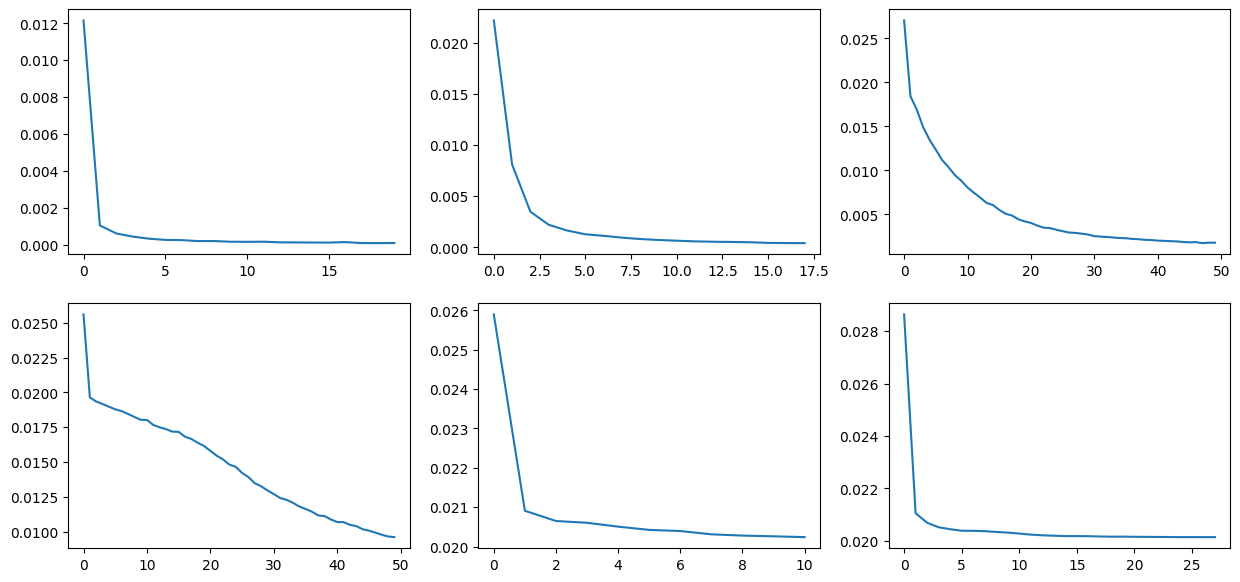

In [35]:
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
ax[0,0].plot(losses[0])
ax[0,1].plot(losses[1])
ax[0,2].plot(losses[2])
ax[1,0].plot(losses[3])
ax[1,1].plot(losses[4])
ax[1,2].plot(losses[5])


In [36]:
TEST_PREDS = [models[i](X_TEST[i]).detach() for i in range(len(models))]

In [37]:
r2_losses = [r2_score(TEST_PREDS[i].detach(), Y_TEST[i].detach()) for i in range(len(TEST_PREDS))]

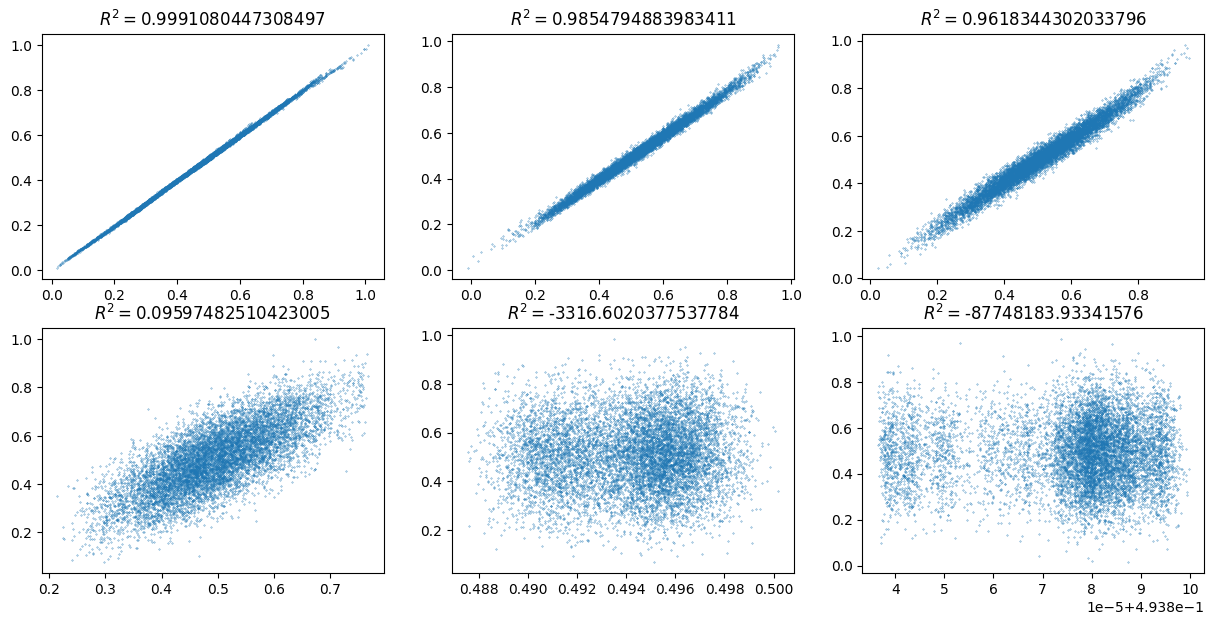

In [38]:
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
ax[0,0].scatter(TEST_PREDS[0], Y_TEST[0],marker='.', s=.3)
ax[0,1].scatter(TEST_PREDS[1], Y_TEST[1],marker='.', s=.3)
ax[0,2].scatter(TEST_PREDS[2], Y_TEST[2],marker='.', s=.3)
ax[1,0].scatter(TEST_PREDS[3], Y_TEST[3],marker='.', s=.3)
ax[1,1].scatter(TEST_PREDS[4], Y_TEST[4],marker='.', s=.3)
ax[1,2].scatter(TEST_PREDS[5], Y_TEST[5],marker='.', s=.3)



for ind, i in enumerate(ax.flatten()):
    i.set_title("$R^2 = $" + str(r2_losses[ind]))

I think as sequence length increases, transformer will get better and MLP will get worse. 
Would be interesting to work out how the MLP params increase with sequence length, whereas those of LSTM and Transformer can probably remain the same.

Would be good to have a Fourier decomp the NK landscapes + Dirichlet energy and N max, and then have that for the G protein and empirical datasets. 

In [ ]:
TE